# 18 · Comparación de detectores de esquinas / puntos (OpenCV)

Detectores incluidos:
- **Harris** (`cornerHarris` + NMS y overlay).
- **Shi–Tomasi / Good Features to Track** (`goodFeaturesToTrack`).
- **FAST** (`FastFeatureDetector_create`).
- **ORB** (`ORB_create`).
- **SIFT** (`SIFT_create`) — si no está disponible, se omite automáticamente.



## 1) Cargar imagen

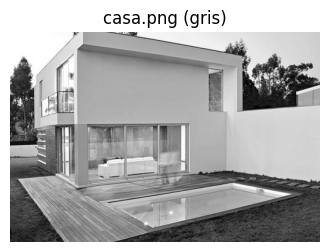

In [8]:
import cv2, numpy as np, matplotlib.pyplot as plt, pandas as pd

IMG_PATH = r"C:\\Users\\20808\\Documents\\Repositorios\\Vision_en_Robotica\\imagenes\\casa.png"

img_bgr = cv2.imread(IMG_PATH, cv2.IMREAD_UNCHANGED)
if img_bgr is None:
    raise FileNotFoundError(f"No se pudo cargar la imagen en {IMG_PATH}")
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(4,4)); plt.imshow(img_gray, cmap='gray'); plt.title("casa.png (gris)"); plt.axis('off'); plt.show()


## 2) Harris (respuesta, NMS y overlay)

Harris: 589 puntos


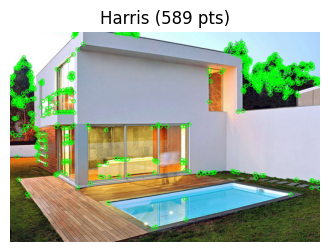

In [9]:
def harris_response(gray, blockSize=2, ksize=3, k=0.04):
    gray_f32 = np.float32(gray)
    R = cv2.cornerHarris(gray_f32, blockSize, ksize, k)
    return R

def nms_harris(R, thresh_rel=0.02):
    R_dil = cv2.dilate(R, None)
    t = float(R.max()) * float(thresh_rel)
    maxima = (R >= R_dil) & (R > t)
    ys, xs = np.where(maxima)
    return np.column_stack([xs, ys]).astype(np.int32)

def draw_points_rgb(rgb, pts, color=(0,255,0), radius=3):
    out = rgb.copy()
    for x,y in pts:
        cv2.circle(out, (int(x),int(y)), radius, color, 1, lineType=cv2.LINE_AA)
    return out

R = harris_response(img_gray, blockSize=2, ksize=3, k=0.04)
harris_pts = nms_harris(R, thresh_rel=0.02)
harris_vis = draw_points_rgb(img_rgb, harris_pts)

print(f"Harris: {len(harris_pts)} puntos")
plt.figure(figsize=(4,4)); plt.imshow(harris_vis); plt.title(f"Harris ({len(harris_pts)} pts)"); plt.axis('off'); plt.show()


## 3) Shi–Tomasi / Good Features to Track

Shi–Tomasi: 500 puntos  |  GFT (modo Harris): 185 puntos


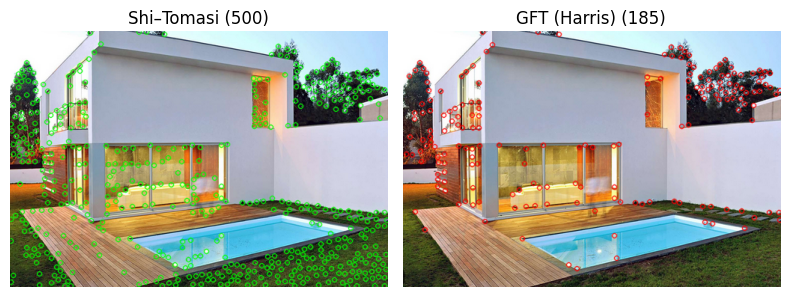

In [10]:
# Shi–Tomasi (useHarrisDetector=False)
shi_pts = cv2.goodFeaturesToTrack(img_gray, maxCorners=500, qualityLevel=0.01, minDistance=7, blockSize=7, useHarrisDetector=False, k=0.04)
shi_pts = np.int32(shi_pts).reshape(-1,2) if shi_pts is not None else np.empty((0,2), np.int32)
shi_vis = draw_points_rgb(img_rgb, shi_pts)

# GFT en modo Harris
gft_harris = cv2.goodFeaturesToTrack(img_gray, maxCorners=500, qualityLevel=0.01, minDistance=7, blockSize=7, useHarrisDetector=True, k=0.04)
gft_harris = np.int32(gft_harris).reshape(-1,2) if gft_harris is not None else np.empty((0,2), np.int32)
gft_harris_vis = draw_points_rgb(img_rgb, gft_harris, color=(255,0,0))

print(f"Shi–Tomasi: {len(shi_pts)} puntos  |  GFT (modo Harris): {len(gft_harris)} puntos")
plt.figure(figsize=(8,4))
plt.subplot(1,2,1); plt.imshow(shi_vis); plt.title(f"Shi–Tomasi ({len(shi_pts)})"); plt.axis('off')
plt.subplot(1,2,2); plt.imshow(gft_harris_vis); plt.title(f"GFT (Harris) ({len(gft_harris)})"); plt.axis('off')
plt.tight_layout(); plt.show()


## 4) FAST

FAST: 2412 puntos


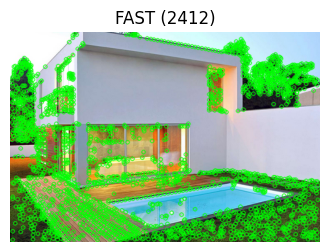

In [11]:
fast = cv2.FastFeatureDetector_create(threshold=20, nonmaxSuppression=True, type=cv2.FAST_FEATURE_DETECTOR_TYPE_9_16)
kps_fast = fast.detect(img_gray, None)
fast_vis = cv2.drawKeypoints(img_rgb, kps_fast, None, color=(0,255,0))
print(f"FAST: {len(kps_fast)} puntos")
plt.figure(figsize=(4,4)); plt.imshow(fast_vis); plt.title(f"FAST ({len(kps_fast)})"); plt.axis('off'); plt.show()


## 5) ORB

ORB: 500 puntos   |   descriptor shape: (500, 32)


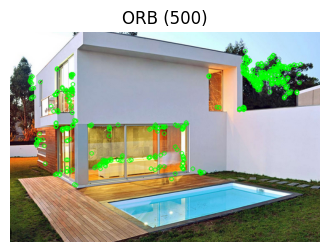

In [12]:
orb = cv2.ORB_create(nfeatures=500, scaleFactor=1.2, nlevels=8)
kps_orb = orb.detect(img_gray, None)
kps_orb, des_orb = orb.compute(img_gray, kps_orb)
orb_vis = cv2.drawKeypoints(img_rgb, kps_orb, None, color=(0,255,0))
print(f"ORB: {len(kps_orb)} puntos   |   descriptor shape: {None if des_orb is None else des_orb.shape}")
plt.figure(figsize=(4,4)); plt.imshow(orb_vis); plt.title(f"ORB ({len(kps_orb)})"); plt.axis('off'); plt.show()


## 6) SIFT (si disponible)

SIFT: 500 puntos   |   descriptor shape: (500, 128)


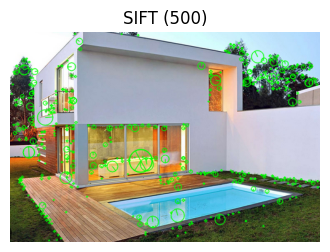

In [13]:
have_sift = hasattr(cv2, 'SIFT_create')
if have_sift:
    sift = cv2.SIFT_create(nfeatures=500)
    kps_sift, des_sift = sift.detectAndCompute(img_gray, None)
    sift_vis = cv2.drawKeypoints(img_rgb, kps_sift, None, color=(0,255,0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    print(f"SIFT: {len(kps_sift)} puntos   |   descriptor shape: {None if des_sift is None else des_sift.shape}")
    plt.figure(figsize=(4,4)); plt.imshow(sift_vis); plt.title(f"SIFT ({len(kps_sift)})"); plt.axis('off'); plt.show()
else:
    print('SIFT no está disponible (cv2.SIFT_create no existe).')


## 7) Resumen de conteos

In [14]:
rows = [
    ['Harris', len(harris_pts)],
    ['Shi–Tomasi', len(shi_pts)],
    ['GFT (modo Harris)', len(gft_harris)],
    ['FAST', len(kps_fast)],
    ['ORB', len(kps_orb)],
]
if 'have_sift' in globals() and have_sift:
    rows.append(['SIFT', len(kps_sift)])

df = pd.DataFrame(rows, columns=['Detector', 'N puntos'])
df


,Detector,N puntos
0,Harris,589
1,Shi–Tomasi,500
2,GFT (modo Harris),185
3,FAST,2412
4,ORB,500
5,SIFT,500


## 8) Interactivo: ajusta parámetros con *sliders*
Usa los controles para ver cómo cambian los puntos detectados y el conteo por detector.


In [ ]:
import ipywidgets as widgets
from IPython.display import display, Markdown

# Copiamos utilidades necesarias de arriba (algunas funciones ya existen en el entorno de ejecución)
def draw_points_rgb(rgb, pts, color=(0,255,0), radius=3):
    out = rgb.copy()
    for x,y in pts:
        cv2.circle(out, (int(x),int(y)), radius, color, 1, lineType=cv2.LINE_AA)
    return out

def harris_pts_with_params(gray, blockSize, ksize, k, thresh_rel):
    R = cv2.cornerHarris(np.float32(gray), blockSize, ksize, k)
    R_dil = cv2.dilate(R, None)
    t = float(R.max()) * float(thresh_rel)
    maxima = (R >= R_dil) & (R > t)
    ys, xs = np.where(maxima)
    return np.column_stack([xs, ys]).astype(np.int32)

def shi_tomasi_pts(gray, maxCorners, qualityLevel, minDistance, blockSize):
    pts = cv2.goodFeaturesToTrack(gray, maxCorners=maxCorners, qualityLevel=qualityLevel,
                                  minDistance=minDistance, blockSize=blockSize,
                                  useHarrisDetector=False, k=0.04)
    if pts is None: 
        return np.empty((0,2), np.int32)
    return np.int32(pts).reshape(-1,2)

def fast_kps(gray, threshold, nonmaxSuppression):
    det = cv2.FastFeatureDetector_create(threshold=threshold, nonmaxSuppression=nonmaxSuppression)
    return det.detect(gray, None)

def orb_kps(gray, nfeatures):
    det = cv2.ORB_create(nfeatures=nfeatures)
    kps = det.detect(gray, None)
    return kps

have_sift = hasattr(cv2, 'SIFT_create')
def sift_kps(gray, nfeatures):
    if not have_sift:
        return []
    det = cv2.SIFT_create(nfeatures=nfeatures)
    kps, _ = det.detectAndCompute(gray, None)
    return kps

# Widgets
w_h_block  = widgets.IntSlider(value=2, min=2, max=10, step=1, description='H.block')
w_h_ksize  = widgets.Dropdown(options=[3,5,7], value=3, description='H.ksize')
w_h_k      = widgets.FloatSlider(value=0.04, min=0.02, max=0.1, step=0.005, readout_format='.3f', description='H.k')
w_h_thr    = widgets.FloatSlider(value=0.02, min=0.001, max=0.1, step=0.001, readout_format='.3f', description='H.thr')

w_shi_max  = widgets.IntSlider(value=400, min=50, max=2000, step=50, description='Shi max')
w_shi_q    = widgets.FloatSlider(value=0.01, min=0.001, max=0.1, step=0.001, readout_format='.3f', description='Shi q')
w_shi_minD = widgets.IntSlider(value=7, min=1, max=30, step=1, description='Shi minD')
w_shi_blk  = widgets.IntSlider(value=7, min=3, max=31, step=2, description='Shi block')

w_fast_thr = widgets.IntSlider(value=20, min=1, max=100, step=1, description='FAST thr')
w_fast_nms = widgets.Checkbox(value=True, description='FAST NMS')

w_orb_nf   = widgets.IntSlider(value=500, min=50, max=2000, step=50, description='ORB nfeat')
w_sift_nf  = widgets.IntSlider(value=400, min=50, max=2000, step=50, description='SIFT nfeat', disabled=not have_sift)

ui_left  = widgets.VBox([w_h_block, w_h_ksize, w_h_k, w_h_thr])
ui_mid   = widgets.VBox([w_shi_max, w_shi_q, w_shi_minD, w_shi_blk])
ui_right = widgets.VBox([w_fast_thr, w_fast_nms, w_orb_nf, w_sift_nf])
ui = widgets.HBox([ui_left, ui_mid, ui_right])
display(ui)

out = widgets.Output()
display(out)

def refresh(*args):
    with out:
        out.clear_output(wait=True)
        # Harris
        h_pts = harris_pts_with_params(img_gray, w_h_block.value, int(w_h_ksize.value), w_h_k.value, w_h_thr.value)
        h_vis = draw_points_rgb(img_rgb, h_pts)
        # Shi–Tomasi
        s_pts = shi_tomasi_pts(img_gray, w_shi_max.value, w_shi_q.value, w_shi_minD.value, w_shi_blk.value)
        s_vis = draw_points_rgb(img_rgb, s_pts, color=(255,0,0))
        # FAST
        kps_f = fast_kps(img_gray, w_fast_thr.value, w_fast_nms.value)
        f_vis = cv2.drawKeypoints(img_rgb, kps_f, None, color=(0,255,0))
        # ORB
        kps_o = orb_kps(img_gray, w_orb_nf.value)
        o_vis = cv2.drawKeypoints(img_rgb, kps_o, None, color=(0,255,0))
        # SIFT
        if have_sift:
            kps_s = sift_kps(img_gray, w_sift_nf.value)
            sft_vis = cv2.drawKeypoints(img_rgb, kps_s, None, color=(0,255,0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        else:
            sft_vis = None
        
        # Mostrar figuras
        import matplotlib.pyplot as plt
        cols = 3 if not have_sift else 4
        plt.figure(figsize=(4*cols, 8))
        plt.subplot(2,cols,1); plt.imshow(h_vis); plt.title(f"Harris ({len(h_pts)})"); plt.axis('off')
        plt.subplot(2,cols,2); plt.imshow(s_vis); plt.title(f"Shi–Tomasi ({len(s_pts)})"); plt.axis('off')
        plt.subplot(2,cols,3); plt.imshow(f_vis); plt.title(f"FAST ({len(kps_f)})"); plt.axis('off')
        if have_sift:
            plt.subplot(2,cols,4); plt.imshow(sft_vis); plt.title(f"SIFT ({len(kps_s)})"); plt.axis('off')
        plt.subplot(2,cols,cols+1); plt.imshow(o_vis); plt.title(f"ORB ({len(kps_o)})"); plt.axis('off')
        plt.subplot(2,cols,cols+2); plt.imshow(img_gray, cmap='gray'); plt.title("Gris"); plt.axis('off')
        plt.tight_layout(); plt.show()

for w in [w_h_block, w_h_ksize, w_h_k, w_h_thr, w_shi_max, w_shi_q, w_shi_minD, w_shi_blk, w_fast_thr, w_fast_nms, w_orb_nf, w_sift_nf]:
    w.observe(refresh, names='value')
refresh()

Output()

**Tips rápidos:**
- **Harris**: sube `H.thr` para quedarte solo con esquinas muy fuertes; `H.k` entre 0.04–0.06.
- **Shi–Tomasi**: `Shi q` es el umbral de calidad (sube para ser más estricto); `minD` controla separación mínima.
- **FAST**: `FAST thr` mayor → menos puntos (más estrictos). `FAST NMS` filtra para evitar puntos muy juntos.
- **ORB/SIFT**: `nfeat` define cuántos puntos máximos intentará reportar el detector.
